In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.optim as optim
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
df = pd.read_csv('C:/Users/ch/Desktop/cuhk/FTEC5580/project2/AMZN.csv')
df.shape

(1510, 7)

## Data Processing
The data was downloaded from Yahoo Finance. It contains the price data of this stock from Jan 2, 2015 to Dec 31, 2020. The symbol is **AMZN**.<p>
First, we are going to conduct some basic analysis on the data.<p>
Then standardize the price &nbsp; $p$  &nbsp;using: &nbsp;&nbsp;  $ p = (p - \mu) / \sigma $ <p>
Next we convert price data to arrays.

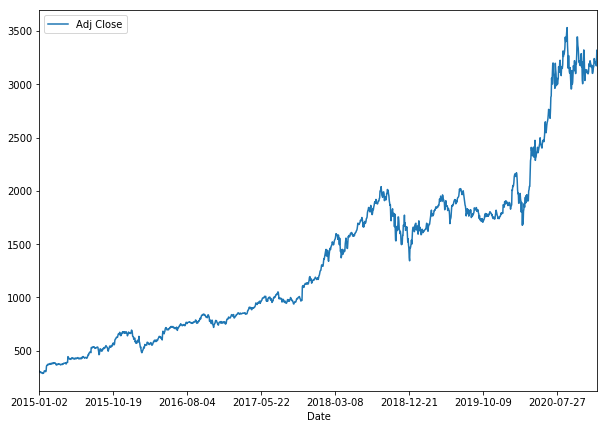

In [3]:
# plot adjusted close price with time

pricePath = np.array(df['Adj Close'])
df.plot(x="Date", y="Adj Close", figsize=(10, 7))

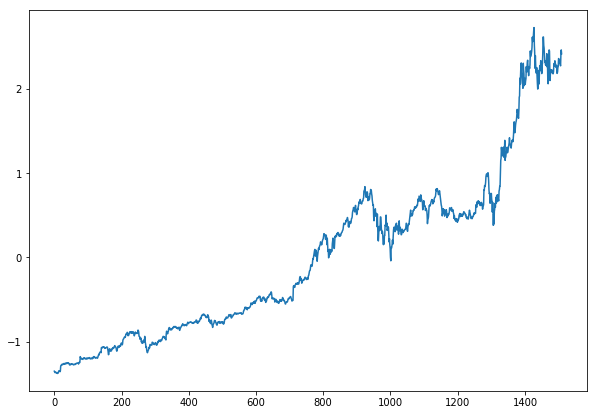

In [4]:
# standardize the price using: p = (p - mean(p)) / sigma
# new data array follows N(0,1)

pricePathStd = (pricePath - np.mean(pricePath)) / np.std(pricePath)
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(pricePathStd)

## Train & Test Set
We use the first five years of data for training your model and the last year's data for testing.

In [7]:
lag = 10

data = np.concatenate([pricePathStd[i: i+lag+1].reshape(1, -1)
                       for i in range(len(pricePathStd)-lag)], 0)
data.shape

(1500, 11)

In [10]:
# divide for different data sets

trainData = torch.from_numpy(data[0:1258]).float()
testData = torch.from_numpy(data[1258:]).float()

# set up Pytorch datasets & dataloaders

trainset = Data.TensorDataset(trainData[:, 0:-1], trainData[:, -1:])
testset = Data.TensorDataset(testData[:, 0:-1], testData[:, -1:])
trainloader = Data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=0)
testloader = Data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=0)

criterion = torch.nn.MSELoss()

## Models
We are going to build two models: 
a Feedforward Neural Network (FNN), 
and 
a Logistic Regression (LR) model.


In [11]:
class FNN_net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(FNN_net, self).__init__()  # inherit methods from torch.nn.Module

        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # h1 layer
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)  # h2 layer
        self.output = torch.nn.Linear(n_hidden2, n_output)  # output layer
        self.n_feature = n_feature

    def forward(self, x):
        x = torch.relu_(self.hidden1(x))
        x = torch.relu_(self.hidden2(x))
        x = self.output(x)
        return x
    
class Logistic(torch.nn.Module):
    def __init__(self, n_feature):
        super(Logistic, self).__init__()
        self.output = torch.nn.Linear(n_feature, 1)

    def forward(self, x):
        x = torch.sigmoid_(self.output(x))
        return x

In [12]:
def test(model, dataloader):
    with torch.no_grad():
        running_loss = 0.0
        batch_num = 0
        for i, data in enumerate(dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = model(inputs)  # forward propagation, get outputs
            loss = criterion(outputs, labels)  # get loss

            # record loss and other statistics
            running_loss += inputs.shape[0] * loss.item()
            batch_num += inputs.shape[0]
    return (running_loss / batch_num)

In [13]:
def train(model, num_epoch, dataloader):
    # SGD with momentum:
    # optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    # Adam:
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_train_list = []  # record training loss
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        batch_num = 0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(inputs.shape, labels.shape)
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)  # forward propagation, get outputs
            # print(outputs.squeeze())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)  # get loss
            loss.backward()  # back propagation, get gradients of loss
            optimizer.step()  # optimize one step

            # record loss and other statistics
            running_loss += inputs.shape[0] * loss.item()
            batch_num += inputs.shape[0]
        loss_train = running_loss / batch_num
        
        loss_train_list.append(loss_train)
    print('Finished Training')
    return loss_train_list

## Analysis
Here we are going to conduct training and the analysis. <p><p>
The MSE here is defined by: <p>
$ MSE=\frac{1}{n} \sum_{i=1}^{m} w_{i}\left(y_{i}-\hat{y}_{i}\right)^{2} $ <p><p><p>
**The Prediction MSE is illustrated by the following table:**


|  Model | Train loss | Test Loss   |
|---------|-------------|------------|
|  FNN   |   0.00091  |  0.01192  |
|   LR   |   0.45705  |  0.90747  |

In [14]:
fnn = FNN_net(10, 30, 30, 1)
lr = Logistic(10)
loss_fnn = train(fnn, 500, trainloader)
loss_lr = train(lr, 500, trainloader)

Finished Training
Finished Training


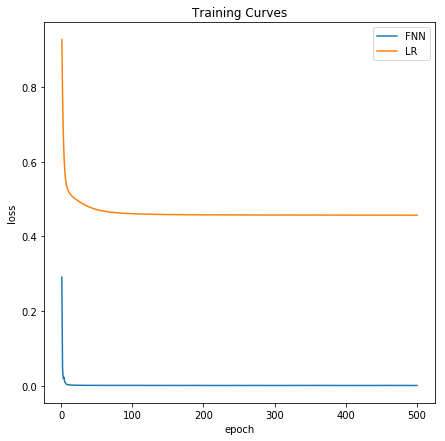

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(range(1, 1+len(loss_fnn)), loss_fnn, label="FNN")
ax.plot(range(1, 1+len(loss_lr)), loss_lr, label="LR")
ax.set_title("Training Curves")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()

      *** Model MSE ***        

  Model | Train loss | Test Loss 
----------------------------------
   FNN  |   0.00076  |  0.01565
    LR  |   0.45689  |  0.90697


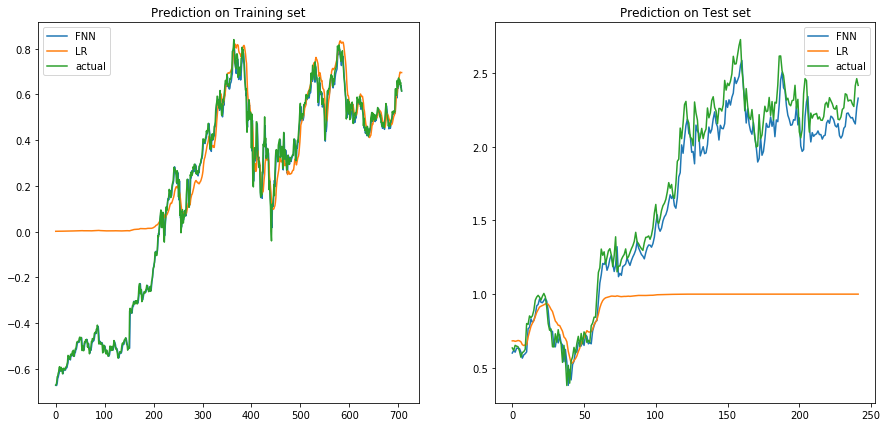

In [23]:
# Here we have a look at the prediction performance in a specific range

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.set_title("Prediction on Training set")
ax2.set_title("Prediction on Test set")
modelname = ["FNN", "LR"]

print("      *** Model MSE ***        ")
print("")
print("  Model | Train loss | Test Loss ")
print("----------------------------------")

for i,j in enumerate([fnn, lr]):
    ax1.plot(j(trainData[550:, :-1])
             [:, ].squeeze().data.numpy(), label=modelname[i])
    ax2.plot(j(testData[:, :-1])
             [:, 0].squeeze().data.numpy(), label=modelname[i])
    print("%6s  |  %8.5f  | %8.5f" % (modelname[i], test(j, trainloader), test(j, testloader)))

ax1.plot(trainData[550:, -1], label="actual")
ax2.plot(testData[:, -1], label="actual")

ax1.legend()
ax2.legend()

      *** Model MSE ***        

  Model | Train loss | Test Loss 
----------------------------------
   FNN  |   0.00076  |  0.01565
    LR  |   0.45689  |  0.90697


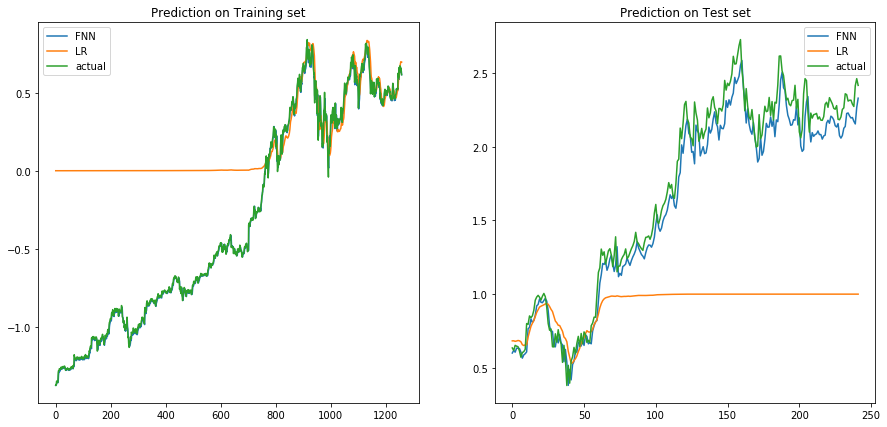

In [19]:
# Here we have a look at the prediction performance for the entire price path

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.set_title("Prediction on Training set")
ax2.set_title("Prediction on Test set")
modelname = ["FNN", "LR"]

print("      *** Model MSE ***        ")
print("")
print("  Model | Train loss | Test Loss ")
print("----------------------------------")

for i,j in enumerate([fnn, lr]):
    ax1.plot(j(trainData[:, :-1])
             [:, ].squeeze().data.numpy(), label=modelname[i])
    ax2.plot(j(testData[:, :-1])
             [:, 0].squeeze().data.numpy(), label=modelname[i])
    print("%6s  |  %8.5f  | %8.5f" % (modelname[i], test(j, trainloader), test(j, testloader)))

ax1.plot(trainData[:, -1], label="actual")
ax2.plot(testData[:, -1], label="actual")

ax1.legend()
ax2.legend()